In [29]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import torch.nn as nn

from diffusers import (
    DiffusionPipeline,
    DDIMScheduler,
    DDPMScheduler,
    UNet2DConditionModel,
    AutoencoderKL,
)
from diffusers.utils import BaseOutput
from transformers import CLIPTextModel, CLIPTokenizer

num_train_timesteps=1000
unet = UNet2DConditionModel(
).from_pretrained('./stable-diffusion-v1-5',
                  subfolder="unet",
                  in_channels=12,
                  out_channels=8,
                  low_cpu_mem_usage=False,
                  ignore_mismatched_sizes=True,
                  local_files_only = True)
vae = AutoencoderKL().from_pretrained('./stable-diffusion-v1-5',subfolder="vae")
scheduler = DDIMScheduler(num_train_timesteps=1000).from_pretrained('./stable-diffusion-v1-5',subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained('./stable-diffusion-v1-5',subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained('./stable-diffusion-v1-5',subfolder="text_encoder")

class FinetuneUnet(nn.Module):
    rgb_latent_scale_factor = 0.18215
    depth_latent_scale_factor = 0.18215
    def __init__(
            self,
            unet: unet,
            vae: AutoencoderKL,
            scheduler: DDIMScheduler,
            text_encoder: CLIPTextModel,
            tokenizer: CLIPTokenizer,
    ):
        super(FinetuneUnet, self).__init__()
        self.unet = unet
        self.vae = vae
        self.scheduler = scheduler
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.empty_text_embed = None

    def __encode_empty_text(self):
        """
        Encode text embedding for empty prompt
        """
        text_inputs = self.tokenizer(
            "",
            padding="do_not_pad",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids.to(self.text_encoder.device)
        self.empty_text_embed = self.text_encoder(text_input_ids)[0].to(torch.float32)

    def encode_3c(self, render: torch.Tensor) -> torch.Tensor:
        # encode
        h = self.vae.encoder(render)
        moments = self.vae.quant_conv(h)
        mean, logvar = torch.chunk(moments, 2, dim=1)
        # scale latent
        render_latent = mean * self.rgb_latent_scale_factor
        return render_latent

    def forward(self,render_depth_normal_latent):
        device = render_depth_normal_latent.device

        render_latent = render_depth_normal_latent[:,0:4,:,:]
        depth_normal_latent = render_depth_normal_latent[:,4:12,:,:]

        # noise is 8 channel
        noise = torch.randn((render_latent.shape[0],8,render_latent.shape[2],render_latent.shape[3]), device=device) # noise for depth_normal_latent
        bs = render_latent.shape[0]
        timesteps = torch.randint(
            0, self.scheduler.config.num_train_timesteps, (bs,), device=device,
            dtype=torch.int64
        )
        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_depth_normal = self.scheduler.add_noise(depth_normal_latent, noise, timesteps)

        # empty text embedding
        if self.empty_text_embed is None:
            self.__encode_empty_text()
        batch_empty_text_embed = self.empty_text_embed.repeat(
            (render_latent.shape[0], 1, 1)
        )  # [B, 2, 1024]

        unet_input = torch.cat([render_latent,noisy_depth_normal],dim=1)
        pred_noise = self.unet(unet_input,timesteps,encoder_hidden_states=batch_empty_text_embed).sample
        return pred_noise, noise

Some weights of UNet2DConditionModel were not initialized from the model checkpoint at ./stable-diffusion-v1-5 and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 12, 3, 3]) in the model instantiated
- conv_out.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([8]) in the model instantiated
- conv_out.weight: found shape torch.Size([4, 320, 3, 3]) in the checkpoint and torch.Size([8, 320, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
device = 'cuda'
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)
text_encoder.text_model.embeddings.token_embedding.requires_grad_(False)

vae.eval()
text_encoder.text_model.embeddings.token_embedding.eval()
text_encoder.eval()
unet.eval()

UNet2DConditionModel(
  (conv_in): Conv2d(12, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=32

In [31]:
device = 'cuda'
model = FinetuneUnet(unet=unet, vae=vae, scheduler=scheduler, text_encoder=text_encoder, tokenizer=tokenizer)
model = model.to(device)
checkpoint = torch.load('./unet_finetune.pth', map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [32]:
latent_scale_factor = 0.18215

In [33]:
def __encode_empty_text():
    """
    Encode text embedding for empty prompt
    """
    text_inputs = tokenizer(
        "",
        padding="do_not_pad",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids.to(text_encoder.device)
    empty_text_embed = text_encoder(text_input_ids)[0].to(torch.float32)
    return empty_text_embed

def decode_3c(latent):
    # scale latent
    latent = latent / latent_scale_factor
    # decode
    z = vae.post_quant_conv(latent)
    decoded_latent = vae.decoder(z)
    # # mean of output channels
    # depth_mean = stacked.mean(dim=1, keepdim=True)
    return decoded_latent

def single_infer(render_latent, num_inference_steps, show_pbar=True):
    device = render_latent.device
    # Set timesteps
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps  # [T]

    # Initial depth map (noise)
    depth_latent = torch.randn(
        render_latent.shape, device=device, dtype=torch.float32
    )  # [B, 4, h, w]
    # Initial normal map (noise)
    normal_latent = torch.randn(
        render_latent.shape, device=device, dtype=torch.float32
    )  # [B, 4, h, w]

    empty_text_embed = __encode_empty_text()
    batch_empty_text_embed = empty_text_embed.repeat(
        (render_latent.shape[0], 1, 1)
    )  # [B, 2, 1024]

    # Denoising loop
    if show_pbar:
        iterable = tqdm(
            enumerate(timesteps),
            total=len(timesteps),
            leave=False,
            desc=" " * 4 + "Diffusion denoising",
        )
    else:
        iterable = enumerate(timesteps)

    for i, t in iterable:
        unet_input = torch.cat(
            [render_latent, depth_latent, normal_latent], dim=1
        )  # this order is important

        # predict the noise residual
        noise_pred_depth_normal = unet(
            unet_input, t, encoder_hidden_states=batch_empty_text_embed
        ).sample  # [B, 4, h, w]

        # compute the previous noisy sample x_t -> x_t-1
        depth_latent  = scheduler.step(noise_pred_depth_normal[:,0:4,:,:], t, depth_latent).prev_sample
        normal_latent = scheduler.step(noise_pred_depth_normal[:,4:8,:,:], t, normal_latent).prev_sample
    torch.cuda.empty_cache()
    depth  = decode_3c(depth_latent)
    normal = decode_3c(normal_latent)

    # clip prediction
    depth = torch.clip(depth, -1.0, 1.0)
    # shift to [0, 1]
    depth = (depth + 1.0) / 2.0

    normal = torch.clip(normal, -1.0, 1.0)
    # shift to [0, 1]
    normal = (normal + 1.0) / 2.0

    return depth, normal

In [34]:
def show(images,save=False,name='default'):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(20, 10))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        # image = (image + 1) / 2
        if image.shape[2] == 1:
            plt.subplot(5, 10, i + 1)
            plt.imshow(image,cmap='gray')
            plt.axis('off')
            
        else:
            plt.subplot(5, 10, i + 1)
            plt.imshow(image)
            plt.axis('off')
    if save:
        plt.savefig(f'{name}.pdf') 

    plt.show()

def show_error_map(pred, gd, save=False,name='default'):
    # Ensure the tensors have the same shape
    assert pred.shape == gd.shape, "Input tensors must have the same shape"
    pred = pred.mean(dim=1, keepdim=True)
    gd = gd.mean(dim=1, keepdim=True)
    # Calculate the absolute difference between the prediction and ground truth
    error_map = torch.abs(pred - gd) * 10
    show(error_map,save,name)

In [35]:
render = np.load('./render_depth_normal_latent.npy').astype(np.float32)
print(render.shape)
# render = render.transpose(0, 3, 1, 2)
print(render.shape)
# data = render[0:1000]
data = render

# data = np.concatenate([render,render,render],axis=1)
print(data.shape)
print(type(data[0][1][1][1]))

(5400, 12, 32, 32)
(5400, 12, 32, 32)
(5400, 12, 32, 32)
<class 'numpy.float32'>


In [36]:
print(data.shape)
i = 1500
data = data[i:i+20,:,:,:]
data = torch.from_numpy(data).to(device)
print(data.shape)

(5400, 12, 32, 32)
torch.Size([20, 12, 32, 32])


In [37]:
depth, normal = single_infer(data[:,0:4,:,:],num_inference_steps = 999)

    Diffusion denoising:   0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.25 GiB. GPU 0 has a total capacty of 23.69 GiB of which 309.75 MiB is free. Process 3763 has 2.64 GiB memory in use. Including non-PyTorch memory, this process has 19.87 GiB memory in use. Of the allocated memory 16.71 GiB is allocated by PyTorch, and 2.84 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(depth.shape)

torch.Size([20, 3, 256, 256])


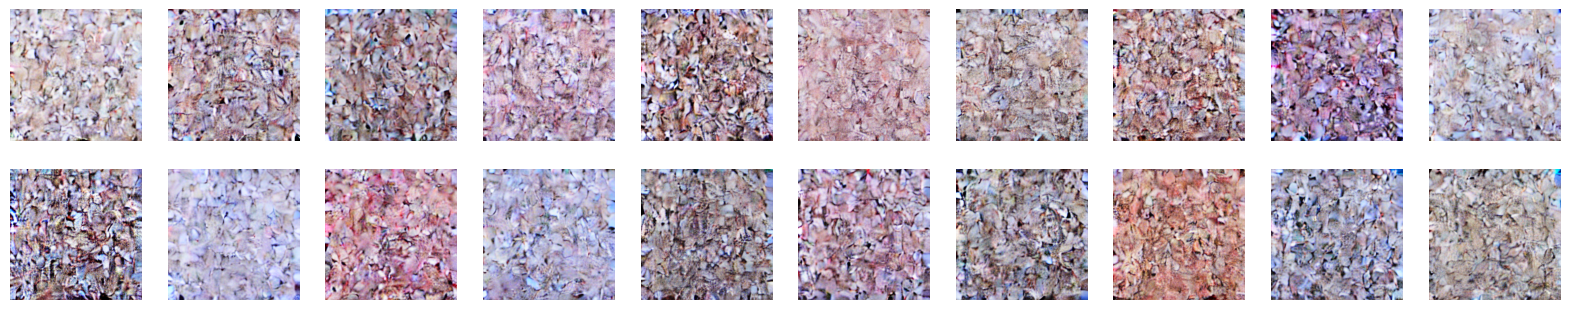

In [ ]:
show(depth,save=True,name='depth3_100')

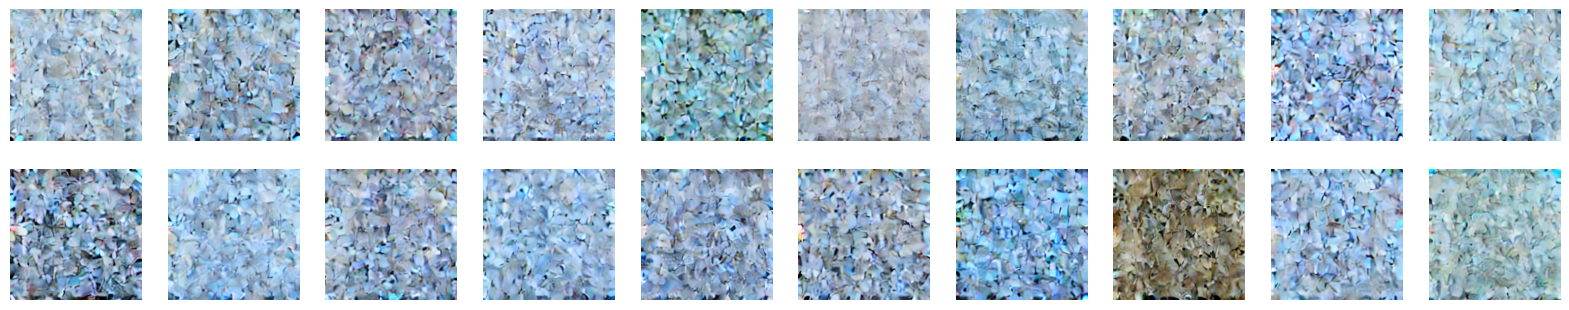

In [ ]:
show(normal)

In [ ]:
render.shape

(5400, 12, 32, 32)

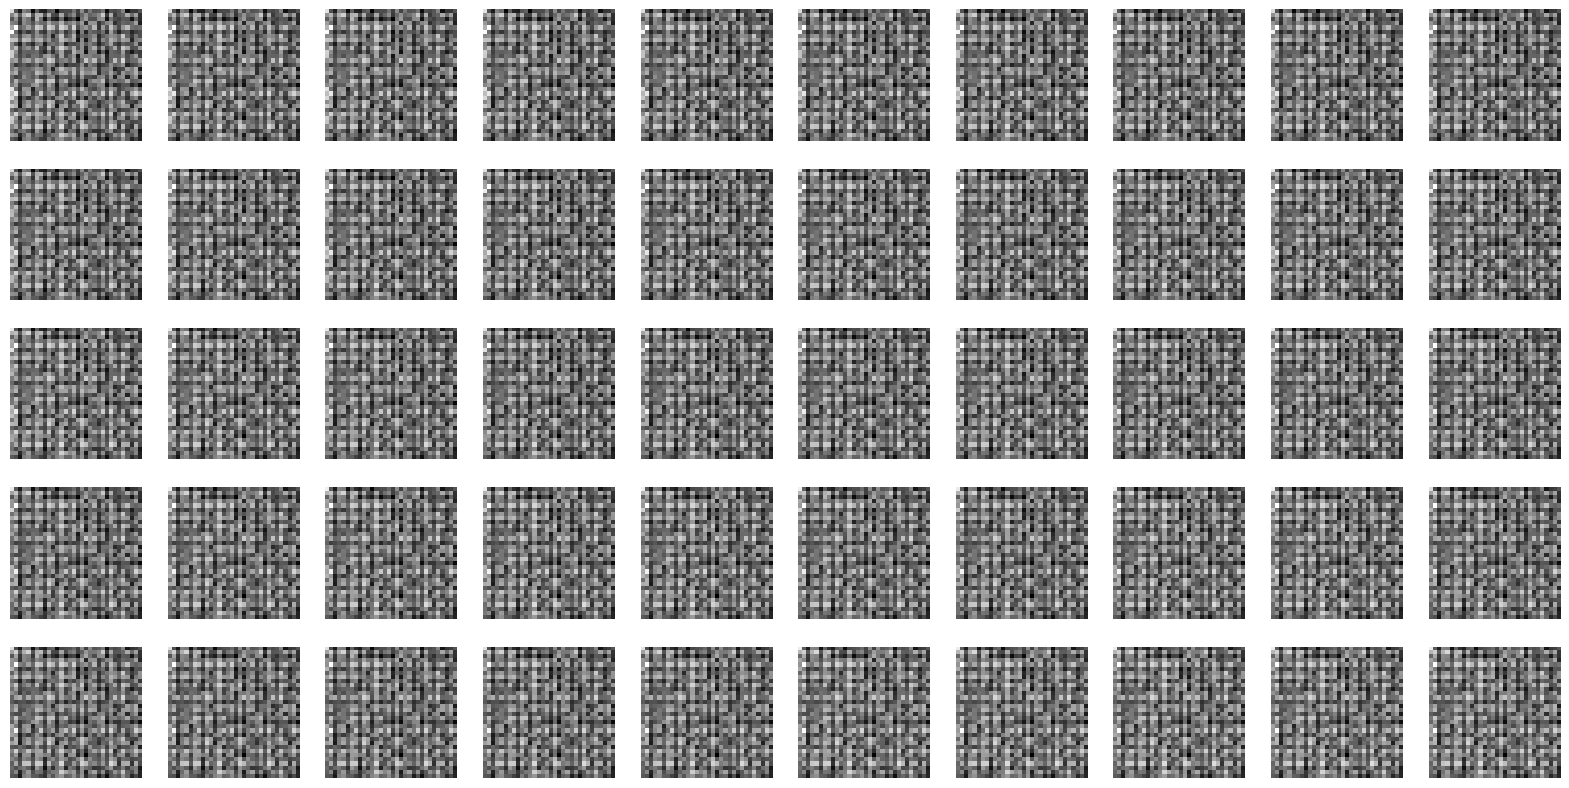

In [ ]:
i = 2000
show(render[i:i+50,0:1,:,:])